In [ ]:
#| default_exp datasets

In [ ]:
#|export
from __future__ import annotations
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F

from datasets import load_dataset,load_dataset_builder

In [ ]:
import torchvision.transforms.functional as TF
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

In [ ]:
import logging
logging.disable(logging.WARNING)

## Hugging Face Datasets

In [ ]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [ ]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [ ]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, dataset_name='fashion_mnist')}

In [ ]:
dsd = load_dataset(name)
dsd

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [ ]:
train,test = dsd['train'],dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [ ]:
x,y = ds_builder.info.features

In [ ]:
x,y

('image', 'label')

In [ ]:
x,y = 'image','label'
img = train[0][x]
img

In [ ]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

In [ ]:
featy = train.features[y]
featy

ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [ ]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [ ]:
train['label'][:5]

[9, 0, 0, 3, 0]

In [ ]:
def collate_fn(b):
    return {x:torch.stack([TF.to_tensor(o[x]) for o in b]),
            y:tensor([o[y] for o in b])}

In [ ]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [ ]:
def transforms(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

In [ ]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape,b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [ ]:
def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [ ]:
transformi = inplace(_transformi)

In [ ]:
r = train.with_transform(transformi)[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

In [ ]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [ ]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape,r[y]

(torch.Size([784]), 9)

In [ ]:
d = dict(a=1,b=2,c=3)
ig = itemgetter('a','c')
ig(d)

(1, 3)

In [ ]:
class D:
    def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

In [ ]:
d = D()
ig(d)

(1, 3)

In [ ]:
list(tdsf.features)

['image', 'label']

In [ ]:
batch = dict(a=[1],b=[2]), dict(a=[3],b=[4])
default_collate(batch)

{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}

In [ ]:
#|export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f

In [ ]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb,xb = next(iter(dlf))
xb.shape,yb

(torch.Size([4]), [9, 0, 0, 3, 0])

## Plotting images

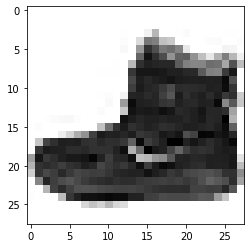

In [ ]:
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img[0]);

In [ ]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute')):
        im = im.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

In [ ]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on `ax`.



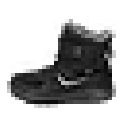

In [ ]:
show_image(img, figsize=(2,2));

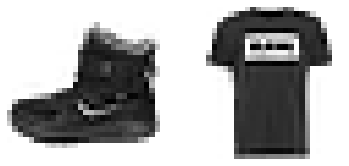

In [ ]:
fig,axs = plt.subplots(1,2)
show_image(img, axs[0])
show_image(xb[1], axs[1]);

In [ ]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = array([ax])
    return fig,ax

In [ ]:
from nbdev.showdoc import show_doc

In [ ]:
show_doc(subplots)

---

[source](https://github.com/fastai/course22p2/blob/master/miniai/datasets.py#L50){target="_blank" style="float:right; font-size:smaller"}

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None, sharex=False, sharey=False, squeeze=True,
>                subplot_kw=None, gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool | False |  |
| sharey | bool | False |  |
| squeeze | bool | True |  |
| subplot_kw | NoneType | None |  |
| gridspec_kw | NoneType | None |  |
| kwargs |  |  |  |

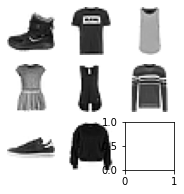

In [ ]:
fig,axs = subplots(3,3, imsize=1)
imgs = xb[:8]
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [ ]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.ceil(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

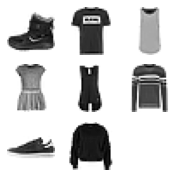

In [ ]:
fig,axs = get_grid(8, nrows=3, imsize=1)
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [ ]:
#|export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int=1, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [ ]:
yb = b['label']
lbls = yb[:8]

In [ ]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

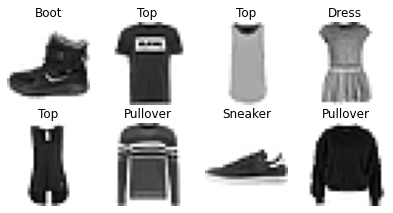

In [ ]:
show_images(imgs, imsize=1.7, titles=titles)

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()